In [6]:
# set same dependency environment to ./Utils/Tracker.py, so python files in this script can access the same environment as Tracker.py
import sys
sys.path.append(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils')

from DDBSCAN import Raster_DBSCAN
from LiDARBase import *
from GenBckFile import *
from SaveTrajectoryTools import save_result
from ExamPcapStartTime import get_pcap_start_time
import pandas as pd
import os
from p_tqdm import p_umap
from functools import partial
from threading import Thread,Event

In [10]:
A = np.array([ # x,y,x',y'
    [1,0,1,0],
    [0,1,0,1],
    [0,0,1,0],
    [0,0,0,1],
])
Q = np.diag([1,1,0.1,0.1])
R = np.diag([1,1])
P_em = np.diag([1.53,1.53,2.2,2.2])

H = np.array([
    [1,0,0,0],
    [0,1,0,0]
])

# this has to loop
"""
When we click on the tracking mode, it creates a MOT object, and trying to initialize the tracking operation by detecting the first frame that some objects exist.
Once some objects are detected, just forward. 
"""

class MOT():
    def __init__(self,tracking_parameter_dict, thred_map):
        """
        background_update_time : background update time (sec)
        """
        
        # if no data in pcap, then it's False
        self.if_pcap_valid = True
        self.if_initialized = False 
        # params for clustering and background sampling
        self.bck_radius = tracking_parameter_dict['bck_radius']
        self.win_size = (tracking_parameter_dict['win_height'],tracking_parameter_dict['win_width'])
        self.eps = tracking_parameter_dict['eps'] 
        self.min_samples = tracking_parameter_dict['min_samples']
        self.missing_thred = tracking_parameter_dict['missing_thred']

        
        self.db = Raster_DBSCAN(window_size=self.win_size,eps = self.eps,min_samples= self.min_samples,Td_map_szie=(32,1800))
        ###
        self.thred_map = thred_map     
        self.start_timestamp = 0    
        ###
        self.Tracking_pool = {}
        self.Off_tracking_pool = {}
        self.Global_id = 0
        self.CurFrame = 0
        self.start_timestamp = 0
        self.cur_mea = None
        self.cur_app = None
        self.cur_unique_label = None
        self.cur_Td_map = None
        self.cur_Labeling_map = None
        self.point_cloud_save_path = None
        self.trajectory_save_path = None
        self.if_save_point_cloud = None
        self.UTC_time_diff = None

    def initialization(self,Frame):
        # you should set up some initial status, we should code the logic in the main loop. 
        
        Td_map = Frame
        Foreground_map = ~(np.abs(Td_map - self.thred_map) <= self.bck_radius).any(axis = 0)
        Labeling_map = self.db.fit_predict(Td_map = Td_map,Foreground_map = Foreground_map)
        mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)
        self.CurFrame += 1
        if len(unique_label_init) == 0:
        # No object in initial frame
            return False
        self.cur_Labeling_map = Labeling_map
        self.cur_Td_map = Td_map
        self.cur_mea = mea_init
        self.cur_app = app_init 
        # some appearance feature 
        self.cur_unique_label = unique_label_init
        # m: n x 2 x 2 x 1 (n objects , 2 repr point, x and y, 1 col )
        n_observed = self.cur_mea.shape[0]
        n_repr = self.cur_mea.shape[1]
        n_offset_dim = A.shape[0] - self.cur_mea.shape[2]
        state_cur = np.concatenate([self.cur_mea,np.zeros((n_observed,n_repr,n_offset_dim,1))],axis = 2)
        P_cur = np.full((n_observed,2,P_em.shape[0],P_em.shape[1]),P_em)
        # s: n x 2 x 4 x 1: x,y,vx,vy

        """
        Create initial detections
        """

        for i,label in enumerate(self.cur_unique_label):
            create_new_detection(self.Tracking_pool,self.Global_id,P_cur[i],state_cur[i],
            self.cur_app[i],label,self.cur_mea[i],self.CurFrame)
            self.Global_id += 1
        # Found objects in initial frame
        self.if_initialized = True
        return True

    def mot_tracking_step(self, Frame):
        if Frame is None:
            return False
        Td_map = Frame
        glb_ids,state_cur,app_cur,unique_label_cur,P_cur = [],[],[],[],[]
        for glb_id in self.Tracking_pool.keys():
            glb_ids.append(glb_id)
            P_cur.append(self.Tracking_pool[glb_id].P)
            state_cur.append(self.Tracking_pool[glb_id].state)
            app_cur.append(self.Tracking_pool[glb_id].apperance)
            # mea_cur.append(self.Tracking_pool[glb_id].mea_seq[-1])
            unique_label_cur.append(self.Tracking_pool[glb_id].label_seq[-1])

        # mea_cur = np.array(mea_cur)
        glb_ids = np.array(glb_ids)
        state_cur = np.array(state_cur)
        app_cur = np.array(app_cur)
        unique_label_cur = np.array(unique_label_cur)
        P_cur = np.array(P_cur)
        # state_cur: n x 2 x 4 x 1
        Foreground_map = ~(np.abs(Td_map - self.thred_map) <= self.bck_radius).any(axis = 0)
        Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

            # m: n x 2 x 2 x 1 (n objects , 2 repr point, x and y, 1 col )
            # app: n x 1 x 7 x 1
            # first repr point refers to the one with lower azimuth id 
        mea_next,app_next,unique_label_next,Labeling_map = extract_xy(Labeling_map,Td_map)

        if len(glb_ids) >0: # we have tracklets in current pool
            state_cur_,P_cur_ = state_predict(A,Q,state_cur,P_cur) 
            if len(unique_label_next) > 0: # detected something in next frame
                    
                    # app_next : n x 7 x 1
                    State_affinity = get_affinity_IoU(app_cur,app_next,unique_label_next,
                     unique_label_cur,self.cur_Labeling_map,Labeling_map)
                    # assiciated_ind for unique_label_next and unique_label_cur
                    associated_ind_cur,associated_ind_next = linear_assignment(State_affinity)
                    # in a but not in b
                    failed_tracked_ind = np.setdiff1d(np.arange(len(glb_ids)),associated_ind_cur) 
                    new_detection_ind = np.setdiff1d(np.arange(len(unique_label_next)),associated_ind_next)
                    if ( len(failed_tracked_ind) > 0 ) & (len(new_detection_ind) > 0):
                        State_affinity_kalman = get_affinity_kalman(failed_tracked_ind,new_detection_ind,state_cur_,mea_next,P_cur_)
                        failed_tracked_ind_,new_detection_ind_ = linear_assignment_kalman(State_affinity_kalman)

                        if len(failed_tracked_ind_) > 0:
                            associated_ind_cur = np.concatenate([associated_ind_cur,failed_tracked_ind[failed_tracked_ind_]]).astype(int)
                            associated_ind_next = np.concatenate([associated_ind_next,new_detection_ind[new_detection_ind_]]).astype(int)
                    """
                    Failed tracking and new detections
                    """
                    failed_tracked_ind = np.setdiff1d(np.arange(len(glb_ids)),associated_ind_cur) 
                    if len(failed_tracked_ind) > 0:
                        for fid in failed_tracked_ind:
                            process_fails(self.Tracking_pool,self.Off_tracking_pool,glb_ids[fid],state_cur_[fid],P_cur_[fid],self.missing_thred)

                    new_detection_ind = np.setdiff1d(np.arange(len(unique_label_next)),associated_ind_next)
                    if len(new_detection_ind) > 0:
                        for n_id in new_detection_ind:
                            n_repr = 2
                            n_offset_dim = 2
                            state_init = np.concatenate([mea_next[n_id],np.zeros((n_repr,n_offset_dim,1))],axis = 1)
                            P_init = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)
                            create_new_detection(self.Tracking_pool,self.Global_id,P_init,state_init,app_next[n_id],
                            unique_label_next[n_id],mea_next[n_id],self.CurFrame)
                            self.Global_id += 1

                    if len(associated_ind_cur) != 0:
                        # print(associated_ind_cur,associated_ind_next)
                        state_cur,P_post = state_update(A,H,state_cur_[associated_ind_cur],P_cur_[associated_ind_cur],R,mea_next[associated_ind_next])
                        glb_ids = glb_ids[associated_ind_cur]
                        # state_cur = state_post[associated_ind_cur]
                        mea_next = mea_next[associated_ind_next]
                        app_next = app_next[associated_ind_next]
                        unique_label_next = unique_label_next[associated_ind_next]
                        """
                        Associate detections 
                        """
                        for i,glb_id in enumerate(glb_ids):
                            associate_detections(self.Tracking_pool,glb_id,state_cur[i],app_next[i],P_post[i],
                                                unique_label_next[i],mea_next[i])
            else:
                 for i,glb_id in enumerate(glb_ids):
                    process_fails(self.Tracking_pool,self.Off_tracking_pool,
                                glb_id,state_cur_[i],P_cur_[i],self.missing_thred)
        else:
            if len(unique_label_next) > 0:
                for n_id, mea in enumerate(mea_next):
                    n_repr = 2
                    n_offset_dim = 2
                    state_init = np.concatenate([mea_next[n_id],np.zeros((n_repr,n_offset_dim,1))],axis = 1)
                    P_init = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)
                    create_new_detection(self.Tracking_pool,self.Global_id,P_init,state_init,
                                            app_next[n_id],unique_label_next[n_id],mea_next[n_id],self.CurFrame)
                    self.Global_id += 1

        self.cur_Labeling_map = Labeling_map
        self.cur_Td_map = Td_map
        self.CurFrame += 1

    def save_trajectory(self,ref_LLH_path,ref_xyz_path,UTC_time_diff):
        ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
        if len(np.unique(ref_xyz[:,2])) == 1:
            np.random.seed(1)
            offset = np.random.normal(-0.521,3.28,len(ref_LLH))
            ref_xyz[:,2] += offset
            ref_LLH[:,2] += offset * 3.2808
        ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
        ref_LLH[:,2] = ref_LLH[:,2]/3.2808
        save_result(self.Off_tracking_pool,ref_LLH,ref_xyz,self.trajectory_save_path,self.start_timestamp, UTC_time_diff)


In [76]:
pcap_file_path = r'D:\LiDAR_Data\US50ANDHighlands\2024-03-16-12-30-00.pcap'
tracking_parameter_dict = {
        'win_width': 13,
        'win_height': 7,
        'eps': 1,
        'min_samples': 10,
        'missing_thred': 5,
        'bck_radius': 0.2,
        'N' : 10,
        'd_thred' : 0.1,
    }
termination_event = Event()
thred_map = gen_bckmap(pcap_file_path, 
                        N = tracking_parameter_dict['N'],
                        d_thred = tracking_parameter_dict['d_thred'],
                        bck_n = 3,
                        termination_event = termination_event)
start_timestamp = get_pcap_start_time(pcap_file_path)
packets_gen = read_packets_offline(pcap_file_path)
frame_generator = parse_packets(packets_gen)

17987it [06:44, 44.48it/s]


In [80]:
UTC_time_diff = 0
if_save_point_cloud = True
point_cloud_path = r'D:\LiDAR_Data\Test'

In [117]:
mot = MOT(tracking_parameter_dict,thred_map)
mot.UTC_time_diff = UTC_time_diff
if if_save_point_cloud:
    mot.point_cloud_save_path = point_cloud_path
mot.start_timestamp = start_timestamp

In [118]:
while not mot.if_initialized:
    try:
        frame = next(frame_generator)
    except StopIteration:
        break
    mot.initialization(frame)

    if if_save_point_cloud:
        save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
    # break

In [ ]:
def get_fore_pcd(Td_map,Labeling_map,Tracking_pool):
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        
        Valid_ind = Td_map[i] != 0 
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)   

    for glb_id in Tracking_pool:
        label_id = Tracking_pool[glb_id].label_seq[-1]
        if label_id != -1:
            Labels[Labels == label_id] = glb_id

    pcd = np.c_[Xs,Ys,Zs,Labels]
    pcd = pcd[pcd[:,3] != -1]

    return pcd

In [119]:
frame = next(frame_generator)
mot.mot_tracking_step(frame)
# save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)


In [121]:
np.unique(mot.cur_Labeling_map)

array([-1,  0,  3,  4,  5, 10, 14, 18, 19], dtype=int64)

In [126]:
labels

[3, 4, 5, 10, -1, 14, 19, 18]

In [128]:
obj_ids

[1, 2, 3, 4, 5, 6, 7, 8]

In [127]:
labels = [mot.Tracking_pool[key].label_seq[-1] for key in mot.Tracking_pool.keys()]
obj_ids = [key for key in mot.Tracking_pool.keys()]

In [114]:
fore_pcd = np.load(r'D:\LiDAR_Data\Test\13.npy')

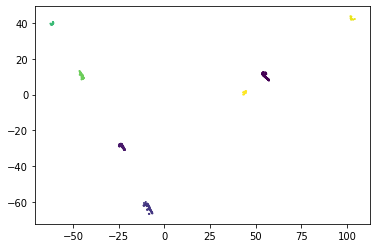

In [115]:
plt.scatter(fore_pcd[:,0],fore_pcd[:,1],s = 1,c = fore_pcd[:,3])